# ghcperf report 

See https://github.com/teh/ghcperf for more details.

In [1]:
%matplotlib inline
import glob
import pandas
import json
import datetime
import seaborn

/nix/store/5d2qd7ax9ww1jc5iavg9s36j56z765a4-python2.7-matplotlib-1.5.1/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
datetime.datetime.utcnow().isoformat()

'2016-03-11T18:43:30.699367'

First copy the data fro S3.

In [3]:
# Abuse /tmp as a cache so we don't do so many GETs
!mkdir -p /tmp/report-data
!aws s3 sync s3://ghcperf-results /tmp/report-data --no-sign-request --quiet
!find /tmp/report-data | wc

    131     131   13409


In [4]:
def parse_name(s):
    # Takes 
    # /tmp/report-data/5a494d8ec688e42601262913172f24cee7a36c9b/perf-1yjvliagav9mf7klzl4qjqs95iggv343-scientific-0.3.4.4.csv
    # returns
    # 5a494d8..., scientific-0.3.4.4
    parts = s.split('/')
    name = parts[4].split('-', 3)[2]
    sha = parts[3]
    return sha, name
def read(x):
    df = pandas.read_csv(x, skiprows=2, header=None, names=["value", "?", "name", "long_value", "?2"])
    sha, package = parse_name(x)
    df['sha'] = sha[:8]
    df['package'] = package
    with open('/tmp/report-data/' + sha + "/" + "commit_meta.json") as f:
        commit = json.load(f)
        df['timestamp'] = commit['committer']['date'] 
    return df

In [5]:
df = pandas.concat([read(x) for x in glob.glob('/tmp/report-data/*/*csv')], axis=0)
df.head()

,value,?,name,long_value,?2,sha,package,timestamp
0,14088.158969,NaN,task-clock,14088158969,100,7ba817c2,mtl,2016-03-11T12:23:30Z
1,24494,NaN,context-switches,14088158969,100,7ba817c2,mtl,2016-03-11T12:23:30Z
2,14844,NaN,cpu-migrations,14088158969,100,7ba817c2,mtl,2016-03-11T12:23:30Z
3,1581144,NaN,page-faults,14088158969,100,7ba817c2,mtl,2016-03-11T12:23:30Z
4,<not supported>,NaN,cycles,0,100,7ba817c2,mtl,2016-03-11T12:23:30Z


In [6]:
df = df[(df.name == "task-clock")]
df['value'] = df['value'].astype('float')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [7]:
plot_df = df[df.package.isin(['aeson', 'text'])]\
    .groupby(['timestamp', 'sha', 'package'])\
    .value\
    .agg(['mean', 'median', 'std'])

# task-clock over time

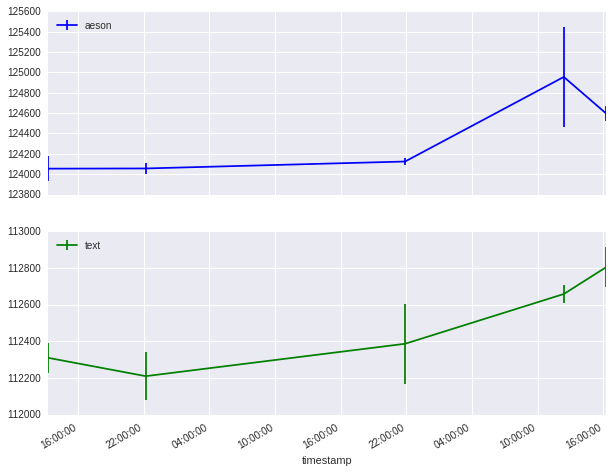

In [15]:
pdf = plot_df.unstack().reset_index(level=1, drop=True)
_ = pdf['mean'].plot(yerr=pdf['std'], subplots=True, figsize=(10, 8))

In [9]:
plot_df

mean         median         std
timestamp           sha      package                                          
2016-03-09 13:16:13 5a494d8e aeson    124054.787897  124017.765628  120.770088
                             text     112309.488031  112286.952585   82.997220
2016-03-09 22:11:57 374f9199 aeson    124056.637195  124054.835207   53.562156
                             text     112209.365236  112228.105015  132.786385
2016-03-10 21:53:27 c42cdb7f aeson    124124.839806  124104.611856   36.493816
                             text     112385.971533  112401.330052  219.707084
2016-03-11 12:23:30 7ba817c2 aeson    124955.540782  124688.456397  490.378315
                             text     112657.546010  112666.318620   51.160759
2016-03-11 16:14:25 2f45cf3f aeson    124598.138842  124593.152554   76.523914
                             text     112803.243838  112802.888654  109.675139